In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime as dt
sns.set_theme(style="whitegrid")

In [2]:
### dataset ---> https://www.kaggle.com/datasets/fiazbhk/airline-data-analysis

In [3]:
connect = sqlite3.connect('travel.sqlite')
cursor = connect.cursor()

In [4]:
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", connect)

In [5]:
tables

,type,name,tbl_name,rootpage,sql
0,table,aircrafts_data,aircrafts_data,2,CREATE TABLE aircrafts_data (\r\n aircraft_...
1,table,airports_data,airports_data,3,CREATE TABLE airports_data (\r\n airport_co...
2,table,boarding_passes,boarding_passes,4,CREATE TABLE boarding_passes (\r\n ticket_n...
3,table,bookings,bookings,5,CREATE TABLE bookings (\r\n book_ref charac...
4,table,flights,flights,6,CREATE TABLE flights (\r\n flight_id intege...
5,table,seats,seats,7,CREATE TABLE seats (\r\n aircraft_code char...
6,table,ticket_flights,ticket_flights,8,CREATE TABLE ticket_flights (\r\n ticket_no...
7,table,tickets,tickets,9,CREATE TABLE tickets (\r\n ticket_no charac...


In [6]:
aircraft_data = pd.read_sql("SELECT * FROM aircrafts_data",connect)
aircraft_data['model'] = aircraft_data['model'].apply(lambda x: json.loads(x)['en'])
aircraft_data

,aircraft_code,model,range
0,773,Boeing 777-300,11100
1,763,Boeing 767-300,7900
2,SU9,Sukhoi Superjet-100,3000
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600
5,319,Airbus A319-100,6700
6,733,Boeing 737-300,4200
7,CN1,Cessna 208 Caravan,1200
8,CR2,Bombardier CRJ-200,2700


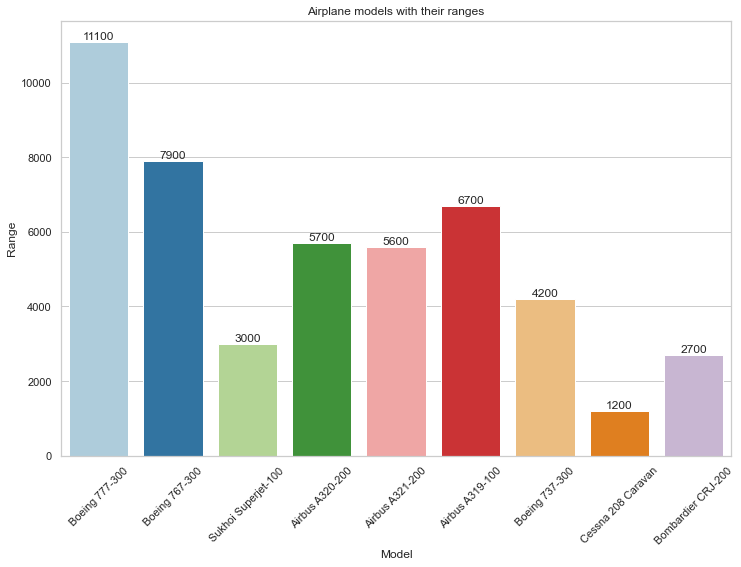

In [7]:
fig,ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x='model',y='range', data=aircraft_data, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
ax.set(title = 'Airplane models with their ranges', xlabel='Model', ylabel='Range')
plt.xticks(rotation=45)
plt.show()

In [8]:
seats_data = pd.read_sql_query("""SELECT aircrafts_data.model, seats.seat_no, seats.fare_conditions
                            FROM seats
                            LEFT JOIN aircrafts_data
                            ON aircrafts_data.aircraft_code=seats.aircraft_code""", connect)
seats_data['model'] = seats_data['model'].apply(lambda x: json.loads(x)['en'])
seats_data = seats_data.groupby('model')['fare_conditions'].value_counts().to_frame().rename(columns = {seats_data.columns[2]:'count'}).reset_index()

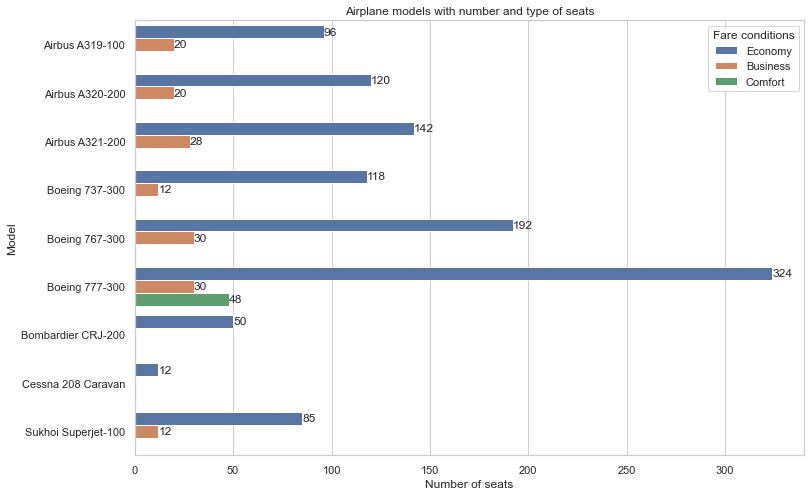

In [9]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.barplot(data = seats_data,y='model',x='count',hue='fare_conditions',orient='h')
ax.set(title = 'Airplane models with number and type of seats', ylabel='Model', xlabel='Number of seats')
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title="Fare conditions")
plt.show()

In [10]:
data = pd.read_sql_query("""SELECT * FROM bookings""", connect)
data['book_date'] = pd.to_datetime(data['book_date'])
data['date'] = data['book_date'].dt.date
bookings = data.groupby('date')[['total_amount']].sum()

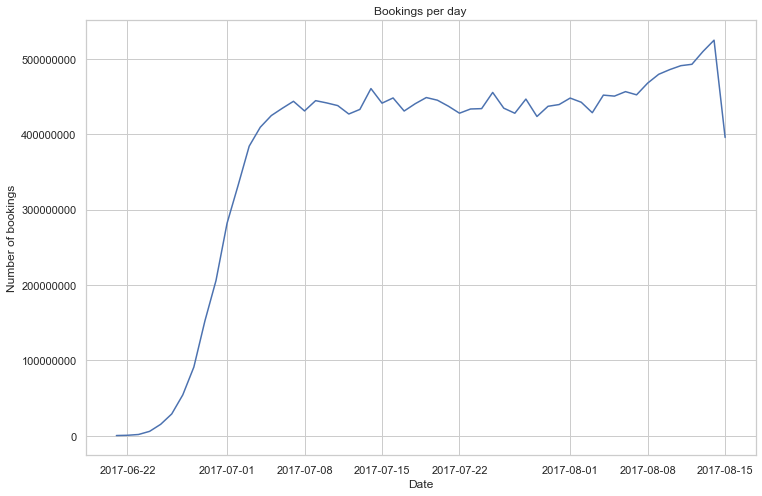

In [11]:
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x= bookings.index, y = bookings['total_amount'])
ax.set(title = 'Bookings per day', xlabel='Date', ylabel='Number of bookings')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [12]:
data = pd.read_sql_query("""SELECT book_date,total_amount,tickets.passenger_id,tickets.ticket_no 
                            FROM bookings
                            LEFT JOIN tickets
                            ON bookings.book_ref=tickets.book_ref""", connect)
data['book_date'] = pd.to_datetime(data['book_date'])
data['date'] = data['book_date'].dt.date
tickets = data.groupby('date')[['date']].count()

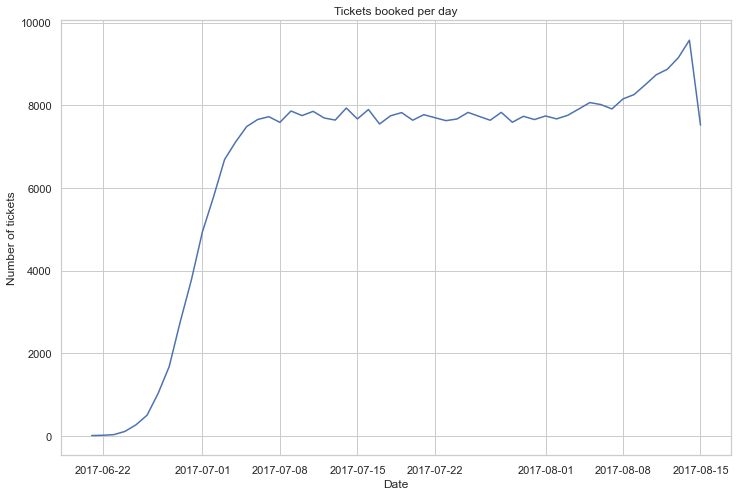

In [13]:
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x= tickets.index, y = tickets['date'])
ax.set(title = 'Tickets booked per day', xlabel='Date', ylabel='Number of tickets')
plt.show()

In [14]:
passengers = data.groupby('passenger_id')['total_amount'].sum().to_frame().sort_values(by='total_amount',ascending=False).head(10)

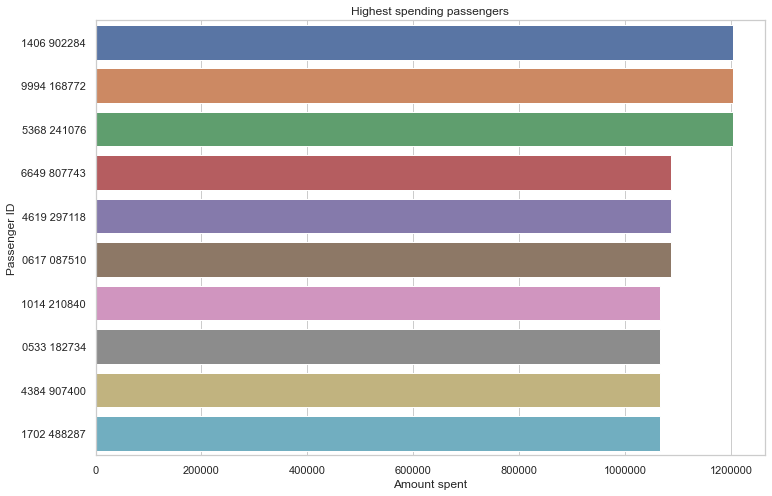

In [15]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(y= passengers.index, x = passengers['total_amount'],orient='h')
ax.set(title = 'Highest spending passengers', xlabel='Amount spent', ylabel='Passenger ID')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [16]:
ticket_data = pd.read_sql_query("""SELECT aircrafts_data.model,count(*) AS ticket_count,sum(amount) AS total_amount,sum(amount)/count(*) AS avg_per_ticket 
                            FROM ticket_flights
                            JOIN flights
                            ON ticket_flights.flight_id=flights.flight_id
                            JOIN aircrafts_data
                            ON flights.aircraft_code=aircrafts_data.aircraft_code
                            GROUP BY flights.aircraft_code""",connect)
ticket_data['model'] = ticket_data['model'].apply(lambda x: json.loads(x)['en'])
ticket_data

,model,ticket_count,total_amount,avg_per_ticket
0,Airbus A319-100,52853,2706163100,51201
1,Airbus A321-200,107129,1638164100,15291
2,Boeing 737-300,86102,1426552100,16568
3,Boeing 767-300,124774,4371277100,35033
4,Boeing 777-300,144376,3431205500,23765
5,Cessna 208 Caravan,14672,96373800,6568
6,Bombardier CRJ-200,150122,1982760500,13207
7,Sukhoi Superjet-100,365698,5114484700,13985


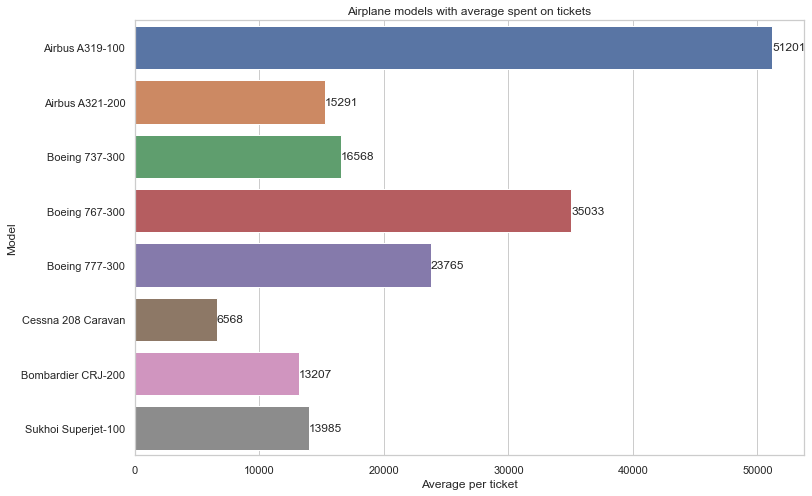

In [17]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.barplot(data = ticket_data,y='model',x='avg_per_ticket',orient='h')
ax.set(title = 'Airplane models with average spent on tickets', ylabel='Model', xlabel='Average per ticket')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [18]:
occupancy_data = pd.read_sql_query("""SELECT aircrafts_data.model,c.average_occupation,c.num_seats,c.occupancy_rate
                            FROM (SELECT occupancy.aircraft_code, avg(occupied_seats) AS average_occupation,total_seats.num_seats,avg(occupied_seats)/total_seats.num_seats AS occupancy_rate
                            FROM (SELECT aircraft_code,flights.flight_id,count(*) AS occupied_seats 
                            FROM boarding_passes
                            INNER JOIN flights
                            ON boarding_passes.flight_id=flights.flight_id
                            GROUP BY aircraft_code,flights.flight_id) 
                            AS occupancy
                            INNER JOIN
                            (SELECT aircraft_code,count(*) AS num_seats 
                            FROM seats
                            GROUP BY aircraft_code)
                            AS total_seats
                            ON occupancy.aircraft_code=total_seats.aircraft_code
                            GROUP BY occupancy.aircraft_code) AS c
                            JOIN aircrafts_data
                            ON c.aircraft_code=aircrafts_data.aircraft_code""",connect)
occupancy_data['model'] = occupancy_data['model'].apply(lambda x: json.loads(x)['en'])
occupancy_data

,model,average_occupation,num_seats,occupancy_rate
0,Boeing 777-300,264.925806,402,0.659019
1,Boeing 767-300,113.937294,222,0.513231
2,Sukhoi Superjet-100,56.812113,97,0.585692
3,Airbus A321-200,88.809231,170,0.522407
4,Airbus A319-100,53.583181,116,0.461924
5,Boeing 737-300,80.255462,130,0.617350
6,Cessna 208 Caravan,6.004431,12,0.500369
7,Bombardier CRJ-200,21.482847,50,0.429657


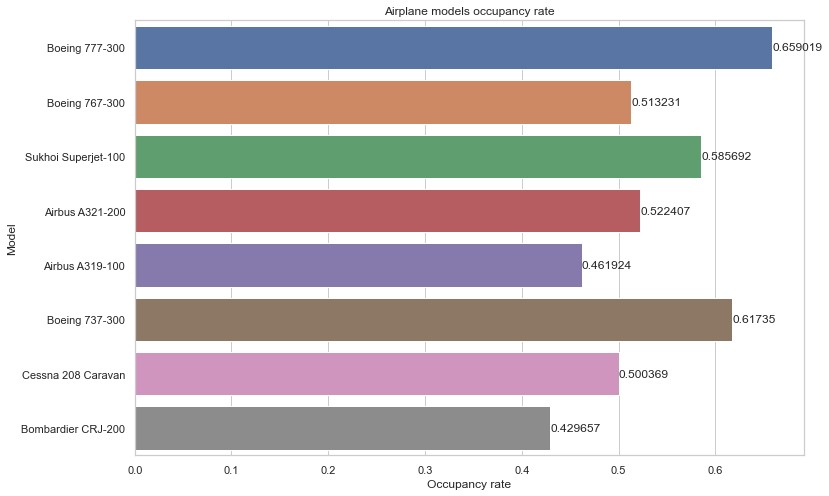

In [19]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.barplot(data = occupancy_data,y='model',x='occupancy_rate',orient='h')
ax.set(title = 'Airplane models occupancy rate', ylabel='Model', xlabel='Occupancy rate')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

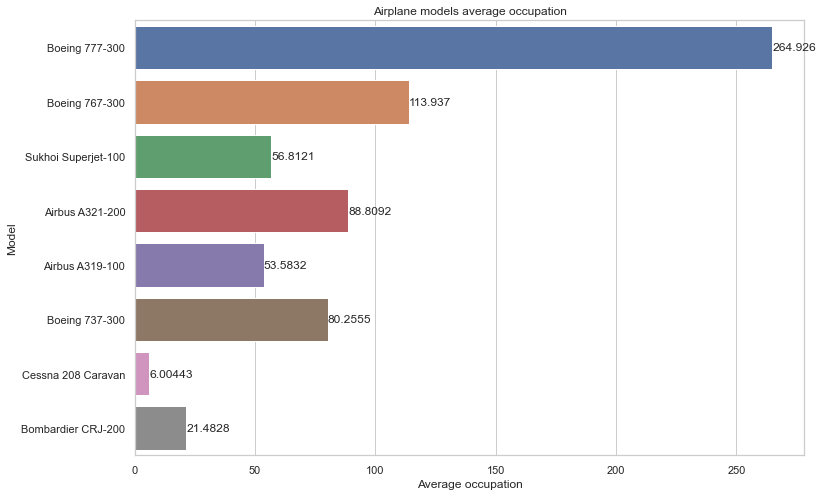

In [20]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.barplot(data = occupancy_data,y='model',x='average_occupation',orient='h')
ax.set(title = 'Airplane models average occupation', ylabel='Model', xlabel='Average occupation')
for container in ax.containers:
    ax.bar_label(container)
plt.show()